In [5]:
import wandb
import matplotlib.pyplot as plt

In [6]:
# !pip install wandb

In [7]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/londanizuma/.netrc


True

In [8]:
# wandb.init(project="my-awesome-project")

In [9]:
# wandb.log({'accuracy' : train_acc, 'loss' : train_loss})

In [14]:
# wandb.finish()
# !pip3 install torch torchvision torchaudio

In [11]:
import random

# Launch 5 simulated experiments
total_runs = 5
for run in range(total_runs):
    # 🐝 1️⃣ Start a new run to track this script
    wandb.init(
      # Set the project where this run will be logged
      project="basic-intro", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",
      "epochs": 10,
      })
  
    # This simple block simulates a training loop logging metrics
    epochs = 10
    offset = random.random() / 5
    for epoch in range(2, epochs):
        acc = 1 - 2 ** -epoch - random.random() / epoch - offset
        loss = 2 ** -epoch + random.random() / epoch + offset
      
      # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"acc": acc, "loss": loss})
      
  # Mark the run as finished
    wandb.finish()

wandb: Currently logged in as: londaniteam (use `wandb login --relogin` to force relogin)


acc,▁▁▅▅█▆▇█
loss,██▅▃▂▂▁▁
acc,0.811
loss,0.17087


acc,▁▅▄▆▇███
loss,█▃▃▃▂▂▁▁
acc,0.87784
loss,0.0993


acc,▁▅▆▆█▇█▇
loss,█▆▄▄▃▁▂▂
acc,0.88117
loss,0.09954


acc,▁▃▇█▇▇██
loss,█▅▃▁▂▂▂▁
acc,0.77043
loss,0.19137


acc,▁▄▄▇▇▇█▇
loss,█▃▁▁▁▁▂▁
acc,0.87198
loss,0.11545


In [15]:
import math
import random
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_dataloader(is_train,batch_size,slice=5):
    "get a training dataloader"
    full_dataset = torchvision.datasets.MNIST(root=".",train=is_train,transform=T.ToTensor(),download=True)
    sub_dataset = torch.utils.data.Subset(full_dataset,indices=range(0,len(full_dataset),slice))
    loader = torch.utils.data.DataLoader(
        dataset = sub_dataset,
        batch_size=batch_size,
        shuffle=True if is_train else False,
        pin_memory=True,num_workers=2
    )
    return loader
def get_model(dropout):
    "A simple model"
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256,10)
    ).to(device)
    return model

def validate_model(model,valid_dl,loss_func,log_images=False,batch_idx=0):
    "Compute perfomance of the model on the valid dataset and log a wandb.table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i,(images,labels) in tqdm(enumerate(valid_dl),leave=False):
            images,labels = images.to(device),labels.to(device)
            
            #forward pass
            outputs = model(images)
            val_loss += loss_func(outputs,labels)*labels.size(0)
            
            #compute accuracy and accumulate
            _,predicted = torch.max(outputs.data,1)
            correct +=(predicted==labels).sum().item()
            
            #log one batch of images to the dasgboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images,predicted,labels,outputs.softmax(dim=1))
    return val_loss/len(valid_dl.dataset),correct/len(valid_dl.dataset)

def log_image_table(images,predicted,labels,probs):
    "Log a wandb.Table with (img,pred,target,scores)"
    #Create a wandb table to log images,labels and predictions
    table = wandb.Table(columns=["image","pred","target"]+[f"score_{i}" for i in range(10)])
    for img,pred,targ,prob in zip(images.to("cpu"),predicted.to("cpu"),labels.to("cpu"),probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255),pred,targ,*prob.numpy())
    wandb.log({"predictions_table":table},commit=False)

In [16]:
device

'cpu'

In [17]:
# Launch 5 experiments, trying different dropout rates
for run in range(5):
    # initialise a wandb run
    wandb.init(
        project="pytorch-intro-Londani",
        name=f"experiment_{run}",
        config={
            "epochs" : 10,
            "batch_size" : 128,
            "lr" : 1e-3,
            "dropout" : random.uniform(0.01,0.80),
        }
    )
    
    # copy your config
    config = wandb.config
    
    # Get data
    train_dl = get_dataloader(is_train=True,batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False,batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset)/config.batch_size)
    
    # A simple MLP model
    model = get_model(config.dropout)
    
    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=config.lr)
    
    # Training
    example_ct = 0
    step_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        for step,(images,labels) in enumerate(tqdm(train_dl,leave=False)):
            images,labels = images.to(device),labels.to(device)
            
            outputs = model(images)
            train_loss = loss_func(outputs,labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            example_ct += len(images)
            metrics = {
                "train/train_loss" : train_loss,
                "train/epoch" : (step +1+(n_steps_per_epoch*epoch))/n_steps_per_epoch,
                "train/example_ct" : example_ct
            }
            
            if step+1<n_steps_per_epoch:
                #Log train metrics to wandb
                wandb.log(metrics)
                
            step_ct +=1
            
        val_loss,accuracy = validate_model(model,valid_dl,loss_func,log_images=(epoch==(config.epochs-1)))
        
        # Log train and validation metrics to wandb
        val_metrics = {
            "val/val_loss":val_loss,
            "val/val_accuracy":accuracy
        }
        wandb.log({**metrics,**val_metrics})
        
        print(f"Train Loss: {train_loss:.3f}, valid Loss: {val_loss:3f},Accuracy{accuracy:.2f}")
    # If you had a test set,this is how you could log is as a summary metric
    
    wandb.summary['test_accuracy'] = 0.8
    
    # close your wandb run
    wandb.finish()
        

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.467, valid Loss: 0.316967,Accuracy0.91


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.261, valid Loss: 0.253520,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.227, valid Loss: 0.222542,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.248, valid Loss: 0.200177,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.160, valid Loss: 0.185771,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.162, valid Loss: 0.173026,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.122, valid Loss: 0.181200,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.086, valid Loss: 0.169459,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.126, valid Loss: 0.159490,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.062, valid Loss: 0.159528,Accuracy0.95



train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▂▂▁▂▂▂▁▂▁▂▂▁▁▂▁▁▂▁
val/val_accuracy,▁▃▅▆▇▇▇▇▇█
val/val_loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,0.8
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.06234
val/val_accuracy,0.9495
val/val_loss,0.15953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.508, valid Loss: 0.368799,Accuracy0.90


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.393, valid Loss: 0.299249,Accuracy0.91


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.563, valid Loss: 0.267761,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.358, valid Loss: 0.249029,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.250, valid Loss: 0.241636,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.248, valid Loss: 0.227987,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.221, valid Loss: 0.218730,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.369, valid Loss: 0.212322,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.312, valid Loss: 0.205046,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.241, valid Loss: 0.200521,Accuracy0.94



train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▃▁▂▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▂▁▁▂▁
val/val_accuracy,▁▃▄▅▆▆▇▇██
val/val_loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,0.8
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.2405
val/val_accuracy,0.9375
val/val_loss,0.20052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.589, valid Loss: 0.349442,Accuracy0.90


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.403, valid Loss: 0.279931,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.386, valid Loss: 0.254579,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.424, valid Loss: 0.236818,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.317, valid Loss: 0.227138,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.397, valid Loss: 0.212870,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.177, valid Loss: 0.204039,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.221, valid Loss: 0.207815,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.190, valid Loss: 0.197704,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.293, valid Loss: 0.197644,Accuracy0.94



train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁
val/val_accuracy,▁▃▅▅▆█▇▇██
val/val_loss,█▅▄▃▂▂▁▁▁▁
test_accuracy,0.8
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.29286
val/val_accuracy,0.938
val/val_loss,0.19764


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.217, valid Loss: 0.280566,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.258, valid Loss: 0.230744,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.179, valid Loss: 0.200145,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.125, valid Loss: 0.177733,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.165, valid Loss: 0.176326,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.059, valid Loss: 0.159236,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.057, valid Loss: 0.163179,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.042, valid Loss: 0.147522,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.044, valid Loss: 0.155369,Accuracy0.95


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.030, valid Loss: 0.147951,Accuracy0.96



train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▄▅▆▆▆▇▇▆█
val/val_loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,0.8
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.03033
val/val_accuracy,0.956
val/val_loss,0.14795


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.484, valid Loss: 0.363428,Accuracy0.90


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.435, valid Loss: 0.291124,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.537, valid Loss: 0.262505,Accuracy0.92


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.403, valid Loss: 0.247759,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.236, valid Loss: 0.233370,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.254, valid Loss: 0.227272,Accuracy0.93


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.266, valid Loss: 0.216453,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.226, valid Loss: 0.210439,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.175, valid Loss: 0.205851,Accuracy0.94


  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Loss: 0.217, valid Loss: 0.202305,Accuracy0.94



train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▂▂▂▁▂▁▂
val/val_accuracy,▁▄▄▆▆▆▇▇██
val/val_loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,0.8
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.21744
val/val_accuracy,0.9395
val/val_loss,0.20231


In [18]:
# start a wandb run
wandb.init(project="alert")

#simulating a model training loop
acc_threshold = 0.3
for training_step in range(1000):
    
    #generate a random number for accuracy
    accuracy = round(random.random()+random.random(),3)
    print(f'Accuracy is: {accuracy}, {acc_threshold}')
    
    #log accuracy to wandb
    wandb.log({"Accuracy" : accuracy})
    
    # If the accuracy is below the threshold, fire the alert and stop the run
    if accuracy <= acc_threshold:
        #Send the wandb Alert
        wandb.alert(
            title="Low Accuracy",
            text=f'Accuracy {accuracy} at step {training_step} is below the acceptable treshold, {acc_threshold}'
        )
        print('Alert triggered')
        break
wandb.finish()

Accuracy is: 1.462, 0.3
Accuracy is: 0.456, 0.3
Accuracy is: 1.521, 0.3
Accuracy is: 1.197, 0.3
Accuracy is: 1.459, 0.3
Accuracy is: 1.388, 0.3
Accuracy is: 1.512, 0.3
Accuracy is: 1.325, 0.3
Accuracy is: 0.999, 0.3
Accuracy is: 0.246, 0.3
Alert triggered



Accuracy,█▂█▆█▇█▇▅▁
Accuracy,0.246


In [94]:
for img,y in loader:
    output = model(img.to(device))
    print(y)
    break

tensor([6, 6])


In [104]:
_,predicted = torch.max(output.data,1)

In [109]:
(predicted == y.to(device)).sum()

tensor(0, device='cuda:0')

In [111]:
output.softmax(dim=1)

tensor([[0.0769, 0.1805, 0.0654, 0.1304, 0.1235, 0.0768, 0.0888, 0.0773, 0.0739,
         0.1066],
        [0.0753, 0.0268, 0.1204, 0.0639, 0.1904, 0.0823, 0.0484, 0.1666, 0.1140,
         0.1120]], device='cuda:0', grad_fn=<SoftmaxBackward>)

<class 'torch.Tensor'> torch.Size([28, 28, 1])


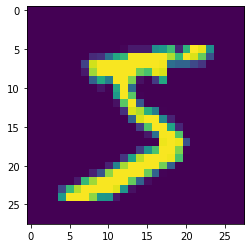

In [55]:
tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])
print(type(tensor_image), tensor_image.shape)

plt.imshow(tensor_image)
plt.show()

In [71]:
input = torch.randn(32, 1, 5, 5)
# >>> # With default parameters
m = nn.Flatten()
output = m(input)
 

In [73]:
output.shape

torch.Size([32, 25])

# Hyperparameter Sweep

In [19]:
sweep_config = {
    'method':'random'
}

In [20]:
metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

In [21]:
parameters_dict = {
    'optimizer':{
        'values':['adam','sgd']
    },
    'fc_layer_size':{
        'values':[128,256,512]
    },
    'dropout':{
        'values':[0.3,0.4,0.5]
    }
}
sweep_config['parameters'] = parameters_dict

In [22]:
parameters_dict.update({
    'epochs':{
        'value':1
    }
})

In [23]:
parameters_dict.update({
    'learning_rate':{
        # a flat distribution betwen 0 and 0.1
        'distribution':'uniform',
        'min':0,
        'max':0.1
    },
    'batch_size':{
        #intergers between 32 and 256
        # with evenly-distributed logarithms
        'distribution':'q_log_uniform_values',
        'q':8,
        'min':32,
        'max':256,
    }
})

In [24]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [25]:
sweep_id = wandb.sweep(sweep_config,project="pythorch-sweep-londani")

Create sweep with ID: ndkkd5pq
Sweep URL: https://wandb.ai/londaniteam/pythorch-sweep-londani/sweeps/ndkkd5pq


In [26]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets,transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    #Initialize a new wandb run
    with wandb.init(config=config):
        #If called by wandb.agent, as below
        #this config will be set by sweep controller
        config = wandb.config
        
        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size,config.dropout)
        optimizer = build_optimizer(network,config.optimizer,config.learning_rate)
        
        for epoch in range(config.epochs):
            avg_loss = train_epoch(network,loader,optimizer)
            wandb.log({"loss":avg_loss,"epoch":epoch})

In [27]:
def build_dataset(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))]
    )
    #download Mnist dataset
    dataset = datasets.MNIST(".",train=True,download=True,transform=transform)
    sub_dataset = torch.utils.data.Subset(
    dataset,indices=range(0,len(dataset),5))
    loader = torch.utils.data.DataLoader(sub_dataset,batch_size=batch_size)
    
    return loader

def build_network(fc_layer_size,dropout):
    network = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,fc_layer_size),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size,10),
        nn.LogSoftmax(dim=1)
    )
    return network.to(device)

def build_optimizer(network,optimizer,learning_rate):
    if optimizer =="sgd":
        optimizer = optim.SGD(network.parameters(),
                             lr=learning_rate,
                             momentum=0.9)
    elif optimizer =="adam":
        optimizer = optim.Adam(network.parameters(),
                              lr=learning_rate)
    return optimizer

def train_epoch(network,loader,optimizer):
    cumu_loss = 0
    for _,(data,target) in enumerate(loader):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        loss = F.nll_loss(network(data),target)
        cumu_loss +=loss.item()
        
        loss.backward()
        optimizer.step()
        
        wandb.log({"batch loss":loss.item()})
        
    return cumu_loss/len(loader)

In [28]:
wandb.agent(sweep_id,train,count=20)

wandb: Agent Starting Run: dcanr38v with config:
wandb: 	batch_size: 208
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.05174113417164289
wandb: 	optimizer: sgd


batch loss,██▇▅▄▄▃▂▂▃▂▃▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.30107
epoch,0
loss,0.62587


wandb: Agent Starting Run: brmv6gq7 with config:
wandb: 	batch_size: 80
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.0860958046278167
wandb: 	optimizer: sgd


batch loss,█▆▄▃▃▃▃▃▃▅▃▃▂▃▅▂▃▃▃▃▂▃▁▃▂▃▂▃▂▁▂▂▂▂▂▂▃▂▁▂
epoch,▁
loss,▁
batch loss,0.36489
epoch,0
loss,0.62637


wandb: Agent Starting Run: twijgnvv with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.01650525465586702
wandb: 	optimizer: adam


batch loss,▄█▅▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.45362
epoch,0
loss,0.92277


wandb: Agent Starting Run: 300gccv1 with config:
wandb: 	batch_size: 144
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.09447605484815902
wandb: 	optimizer: adam


batch loss,▁▇█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.42852
epoch,0
loss,8.6542


wandb: Agent Starting Run: qx3thfme with config:
wandb: 	batch_size: 232
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.024862319008194817
wandb: 	optimizer: sgd


batch loss,██▇▇▆▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.35002
epoch,0
loss,0.74218


wandb: Agent Starting Run: 61vos5qs with config:
wandb: 	batch_size: 200
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.004067777529536832
wandb: 	optimizer: adam


batch loss,█▆▅▄▃▃▂▂▂▂▁▂▂▁▁▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.27483
epoch,0
loss,0.48328


wandb: Agent Starting Run: isn99hem with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.010923415893219868
wandb: 	optimizer: adam


batch loss,█▂▂▂▂▂▁▁▂▃▁▂▁▁▁▂▂▁▁▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▂▁▂
epoch,▁
loss,▁
batch loss,0.89621
epoch,0
loss,0.88209


wandb: Agent Starting Run: c4sl7hcn with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.0938072120754115
wandb: 	optimizer: adam


batch loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,2.13842
epoch,0
loss,6.28894


wandb: Agent Starting Run: co4kjbhc with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.05326970773203743
wandb: 	optimizer: sgd


batch loss,█▄▆▃▅▃▅▃▅▆▄▆▃▃▄▄▄▂▃▆▃▃▂▁▂▅▅▅▃▁▅▅▂▄▃▂▂▃▁▄
epoch,▁
loss,▁
batch loss,1.02341
epoch,0
loss,0.93963


wandb: Agent Starting Run: 346hpl3l with config:
wandb: 	batch_size: 96
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.05402643945074517
wandb: 	optimizer: sgd


batch loss,█▆▄▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▂▁▂▂▁▁
epoch,▁
loss,▁
batch loss,0.32414
epoch,0
loss,0.49567


wandb: Agent Starting Run: 4sud3phw with config:
wandb: 	batch_size: 96
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.029995621740204693
wandb: 	optimizer: sgd


batch loss,█▇▆▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▂▂▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.39501
epoch,0
loss,0.64425


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cegkghcp with config:
wandb: 	batch_size: 56
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0603940002455167
wandb: 	optimizer: adam


batch loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.04808
epoch,0
loss,2.83224


wandb: Agent Starting Run: r2bb7bot with config:
wandb: 	batch_size: 136
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0024829010689932153
wandb: 	optimizer: adam


batch loss,█▆▅▃▃▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▃▂▁▁▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▂
epoch,▁
loss,▁
batch loss,0.60493
epoch,0
loss,0.4953


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wf6o6t6o with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.0008205005317574843
wandb: 	optimizer: adam


batch loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▃▂▂▃▂▂▁▂▁▁▂▂▁▂▁▂▁▁▂▁▁▁
epoch,▁
loss,▁
batch loss,0.47016
epoch,0
loss,0.51516


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mw01gp7c with config:
wandb: 	batch_size: 232
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0665398207856754
wandb: 	optimizer: sgd


batch loss,██▇▆▄▄▃▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.24376
epoch,0
loss,0.63866


wandb: Agent Starting Run: 3gdog3co with config:
wandb: 	batch_size: 176
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.05419642170044821
wandb: 	optimizer: adam


batch loss,▁▇█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.69999
epoch,0
loss,3.49333


wandb: Agent Starting Run: dcwhoopq with config:
wandb: 	batch_size: 184
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.008546437896479797
wandb: 	optimizer: adam


batch loss,▇█▆▅▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂
epoch,▁
loss,▁
batch loss,0.48221
epoch,0
loss,0.61784


wandb: Agent Starting Run: guln996b with config:
wandb: 	batch_size: 232
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.09695204833836114
wandb: 	optimizer: adam


batch loss,▁▄▅██▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,2.14856
epoch,0
loss,38.14403


wandb: Agent Starting Run: eit84pbp with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.031414301534067234
wandb: 	optimizer: adam


batch loss,█▁▂▁▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▂▂▂▁▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁
epoch,▁
loss,▁
batch loss,1.37371
epoch,0
loss,1.4561


wandb: Agent Starting Run: tch0sodm with config:
wandb: 	batch_size: 88
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.08965048894589753
wandb: 	optimizer: adam


batch loss,█▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.63547
epoch,0
loss,7.52043
